# ⋆｡°✩Análise de Sentimentos em postagens do Twitter ᝰ.ᐟ

In [ ]:
import os, re, random, math, time
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, Any
from collections import Counter
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import nltk
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import kagglehub
from typing import List, Tuple, Dict, Iterable, Optional

## Dados


In [47]:
# Download latest version
path = kagglehub.dataset_download("kazanova/sentiment140")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sentiment140


In [48]:
data_dir = Path(path)
csv_path = next(p for p in data_dir.rglob("training.1600000.processed.noemoticon.csv"))

df = pd.read_csv(csv_path, encoding="latin-1", header=None)
df.columns = ["target", "ids", "date", "flag", "user", "text"]
df # df - base original

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [49]:
print(f"\nValores nulos por coluna:\n{df.isnull().sum()}")
print(f"\nDistribuição das classes:\n{df['target'].value_counts()}")


Valores nulos por coluna:
target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

Distribuição das classes:
target
0    800000
4    800000
Name: count, dtype: int64


In [50]:
# Exemplo de textos positivos e negativos
print(f"\n💬 Exemplo de texto negativo:\n{df[df['target'] == 0]['text'].iloc[1]}")
print(f"\n💬 Exemplo de texto positivo:\n{df[df['target'] == 4]['text'].iloc[1]}")


💬 Exemplo de texto negativo:
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

💬 Exemplo de texto positivo:
im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!!


## Pré-processamento dos dados

#### Reprodutibilidade

In [51]:
# Reprodutibilidade
def set_seed(seed: int = 42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

#### Amostra com 50k (estratificado por classe)

In [52]:
# Parâmetros
N = 50_000
n_classes = df["target"].nunique()
total = len(df)

# Ajuste de N se necessário
if N >= total:
    df_small = df.sample(frac=1, random_state=SEED).reset_index(drop=True)
else:
    min_restante = total - N
    if min_restante < n_classes:
        N = total - n_classes
        print(f"[info] N ajustado para {N} para garantir ao menos uma amostra por classe no restante.")

    df_small, _ = train_test_split(
        df,
        train_size=N,
        stratify=df["target"],
        random_state=SEED
    )

#### Normaliza rótulo 0/1 em df_small (Sentiment140 usa 0 e 4)

In [53]:
# Binário: 0=neg, 1=pos
df_small["target"] = (df_small["target"] == 4).astype(int)
df_small.head()

,target,ids,date,flag,user,text
65751,0,1691156478,Sun May 03 17:13:26 PDT 2009,NO_QUERY,dogsforautism,@AngieMC1966 Oh wow. I am so sorry. That's a r...
516586,0,2191103707,Tue Jun 16 04:31:41 PDT 2009,NO_QUERY,ChebbiPon,Tired. Sleepy. Exhausted. Need my beauty sleep!
1211136,1,1989117787,Mon Jun 01 00:24:13 PDT 2009,NO_QUERY,yarono,@Net I wouldn't bet on it...
1418229,1,2057747053,Sat Jun 06 13:35:07 PDT 2009,NO_QUERY,WealthForYou,"I intend to live forever - so far, so good"
397917,0,2056753148,Sat Jun 06 11:43:44 PDT 2009,NO_QUERY,jamiemcflyx,Such bad pains


#### Limpeza de texto + lowercase

- remove/substitui URLs e menções
- remove/substitui '#' (mantém a palavra da hashtag)
- remove/substitui caracteres especiais (fica só letras/dígitos/espaço)
- lowercase

In [54]:
# Aqui SUBSTITUIMOS os simbolos, #, menções, etc. em vez de sumir com tudo
URL_RE   = re.compile(r"http\S+|www\.\S+", re.IGNORECASE)
MENT_RE  = re.compile(r"@\w+")
HASH_RE  = re.compile(r"#(\w+)")
NON_ALN  = re.compile(r"[^a-zà-öø-ÿ0-9\s]+", re.IGNORECASE)

EMOT = [
    (re.compile(r'(:-\)|:\)|\(\:|=\))'),  " <smile> "),
    (re.compile(r'(:-\(|:\(|\):|=/)'),    " <sad> "),
    (re.compile(r'(:-D|:D)'),             " <laugh> "),
]

def basic_clean(s: str) -> str:
    s = str(s).lower()
    s = URL_RE.sub(" <url> ", s)
    s = MENT_RE.sub(" <user> ", s)
    s = HASH_RE.sub(r" \1 ", s)

    s = re.sub(r"!+", " <exc> ", s)
    s = re.sub(r"\?+", " <q> ", s)

    for rx, tok in EMOT:
        s = rx.sub(tok, s)

    s = re.sub(r"(.)\1{2,}", r"\1\1", s)

    # agora as letras dos tokens são minúsculas, então passam pelo filtro:
    s = re.sub(r"[^a-zà-öø-ÿ0-9\s<>]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

df_small["clean"] = df_small["text"].map(basic_clean)
df_small[["target", "text", "clean"]].head(3)

,target,text,clean
65751,0,@AngieMC1966 Oh wow. I am so sorry. That's a r...,<user> oh wow i am so sorry that s a really to...
516586,0,Tired. Sleepy. Exhausted. Need my beauty sleep!,tired sleepy exhausted need my beauty sleep <exc>
1211136,1,@Net I wouldn't bet on it...,<user> i wouldn t bet on it


In [55]:
# Aqui removemos os links, menções, pontuações, hashtags etc.

URL_RE   = re.compile(r"http\S+|www\.\S+", re.IGNORECASE)
MENT_RE  = re.compile(r"@\w+")
EMOT = [
    re.compile(r'(:-\)|:\)|\(\:|=\))'),   # sorrisos
    re.compile(r'(:-\(|:\(|\):|=/)'),     # tristes
    re.compile(r'(:-D|:D)'),              # risos
]
# mantém letras (inclusive acentos), dígitos e espaço
NON_ALNUM_SP = re.compile(r"[^a-zà-öø-ÿ0-9\s]+", re.IGNORECASE)

def basic_clean(s: str, keep_hashtag_word: bool = True) -> str:
    s = str(s).lower()

    # Remover URLs e menções (sem placeholders)
    s = URL_RE.sub("", s)
    s = MENT_RE.sub("", s)

    if keep_hashtag_word:
        s = re.sub(r"#(\w+)", r" \1 ", s) # tira o '#', mantém a palavra
    else:
        s = re.sub(r"#\w+", " ", s)  # remove hashtag inteira

    # Remover emoticons
    for rx in EMOT:
        s = rx.sub(" ", s)

    # Normalizar alongamentos (3+ reps -> 2) — reduz ruído sem criar tokens novos
    s = re.sub(r"(.)\1{2,}", r"\1\1", s)

    # Remover toda a pontuação/símbolos restantes (preserva espaços)
    s = NON_ALNUM_SP.sub(" ", s)

    # Espaços
    s = re.sub(r"\s+", " ", s).strip()
    return s

#df_small["clean"] = df_small["text"].map(lambda t: basic_clean(t, keep_hashtag_word=True))
# df_small[["target", "text", "clean"]].head(3)

#### Stemming (Porter) : reduz variações (play, playing -> play)


In [56]:
'''É um processo mais simples e "bruto" de cortar palavras até sua raiz.
Usa regras de truncagem (ex.: remover sufixos ou prefixos).
Não garante que o resultado seja uma palavra real do idioma.

    Exemplo em português: "amando", "amarei", "amador" → "am"

Vantagem → rápido, computacionalmente barato.
Desvantagem → pode perder semântica ou gerar raízes não interpretáveis.'''

# STEMMED (a partir do CLEAN)
stemmer = PorterStemmer()
def stem_line(s: str) -> str:
    # tokenização por espaço
    return " ".join(stemmer.stem(tok) for tok in s.split())

df_small["stemmed"] = df_small["clean"].map(stem_line)
df_small[["target", "text", "clean", "stemmed"]].head(3)

# ======================== uso
df_small["stemmed"] = df_small["clean"].map(stem_line)
df_small.head(2)

,target,ids,date,flag,user,text,clean,stemmed
65751,0,1691156478,Sun May 03 17:13:26 PDT 2009,NO_QUERY,dogsforautism,@AngieMC1966 Oh wow. I am so sorry. That's a r...,<user> oh wow i am so sorry that s a really to...,<user> oh wow i am so sorri that s a realli to...
516586,0,2191103707,Tue Jun 16 04:31:41 PDT 2009,NO_QUERY,ChebbiPon,Tired. Sleepy. Exhausted. Need my beauty sleep!,tired sleepy exhausted need my beauty sleep <exc>,tire sleepi exhaust need my beauti sleep <exc>


#### Tokenização (Vocabulário)


In [57]:
# Camada extra de limpeza para a lematização

_token_re = re.compile(r"[A-Za-zÀ-ÖØ-öø-ÿ0-9_#@']+")

def simple_tokenize(text: str) -> list[str]:
    """
    Tokenizer simples: lowercase, mantém letras acentuadas, números, # e @.
    Remove pontuações soltas e espaços extras.
    """
    if not isinstance(text, str):
        text = "" if text is None else str(text)
    return [t.lower() for t in _token_re.findall(text)]

#### Lemmatization: reduz variações ("amando", "amarei", "amador" → "amar")

In [58]:
'''É mais sofisticado e linguístico: usa dicionários e análise morfológica.
Reduz palavras à sua forma canônica (lema), que é uma palavra válida.

Considera o contexto e a classe gramatical.

Exemplo: "amando", "amarei", "amador" → "amar"

Vantagem → mantém significado e forma correta da palavra.
Desvantagem → mais lento e depende de recursos linguísticos (dicionários, POS tagging).'''

# ========= Baixar recursos NLTK só se faltar =========
def _ensure_nltk_resource(path, download_name=None):
    try:
        nltk.data.find(path)
    except LookupError:
        nltk.download(download_name or path.split("/")[-1], quiet=True)

_ensure_nltk_resource("corpora/wordnet", "wordnet")
_ensure_nltk_resource("corpora/omw-1.4", "omw-1.4")
# Tagger: tente o nome novo e, se não existir, o antigo
try:
    nltk.data.find("taggers/averaged_perceptron_tagger_eng")
except LookupError:
    try:
        nltk.download("averaged_perceptron_tagger_eng", quiet=True)
    except Exception:
        _ensure_nltk_resource("taggers/averaged_perceptron_tagger", "averaged_perceptron_tagger")

lemmatizer = WordNetLemmatizer()

# ========= Mapeamento Penn Treebank -> WordNet =========
def get_wordnet_pos(treebank_tag: str):
    """
    Converte tag do Penn Treebank para rótulos do WordNet:
      J* -> ADJ, V* -> VERB, N* -> NOUN, R* -> ADV
    """
    if not treebank_tag:
        return wordnet.NOUN
    c = treebank_tag[0]
    if c == 'J':
        return wordnet.ADJ
    if c == 'V':
        return wordnet.VERB
    if c == 'N':
        return wordnet.NOUN
    if c == 'R':
        return wordnet.ADV
    return wordnet.NOUN  # fallback razoável

# ========= Lemmatizer com POS =========
def lemmatize_line(s: str) -> str:
    toks = simple_tokenize(s)
    if not toks:
        return ""
    # pos_tag assume inglês; funciona bem para Sentiment140
    tagged = pos_tag(toks)  # [('running','VBG'), ('dogs','NNS'), ...]
    lemmas = (lemmatizer.lemmatize(tok, get_wordnet_pos(tag)) for tok, tag in tagged)
    return " ".join(lemmas)


# ==================== uso
df_small["lemmatized"] = df_small["clean"].map(lemmatize_line)

In [59]:
df_small[["target", "text", "clean", "stemmed",  "lemmatized"]].head(10)

,target,text,clean,stemmed,lemmatized
65751,0,@AngieMC1966 Oh wow. I am so sorry. That's a r...,<user> oh wow i am so sorry that s a really to...,<user> oh wow i am so sorri that s a realli to...,user oh wow i be so sorry that s a really toug...
516586,0,Tired. Sleepy. Exhausted. Need my beauty sleep!,tired sleepy exhausted need my beauty sleep <exc>,tire sleepi exhaust need my beauti sleep <exc>,tire sleepy exhaust need my beauty sleep exc
1211136,1,@Net I wouldn't bet on it...,<user> i wouldn t bet on it,<user> i wouldn t bet on it,user i wouldn t bet on it
1418229,1,"I intend to live forever - so far, so good",i intend to live forever so far so good,i intend to live forev so far so good,i intend to live forever so far so good
397917,0,Such bad pains,such bad pains,such bad pain,such bad pain
515922,0,I've already lost two of my first years oh no x,i ve already lost two of my first years oh no x,i ve alreadi lost two of my first year oh no x,i ve already lose two of my first year oh no x
1345244,1,mannn miss my mutha effing brother man @CoReyM...,mann miss my mutha effing brother man <user> f...,mann miss my mutha ef brother man <user> fashi...,mann miss my mutha eff brother man user fashio...
320814,0,i think i'm losing someone,i think i m losing someone,i think i m lose someon,i think i m lose someone
1145788,1,@ShotgunShaena That is exiciting girl! I'll ho...,<user> that is exiciting girl <exc> i ll hold ...,<user> that is exicit girl <exc> i ll hold you...,user that be exiciting girl exc i ll hold your...
1199722,1,Listening to Don Potter on this beautiful Sund...,listening to don potter on this beautiful sund...,listen to don potter on thi beauti sunday even...,listen to don potter on this beautiful sunday ...


##   Vocab & encoding

In [60]:
PAD, OOV = "<pad>", "<oov>" # <OOV> -> OUT OF VOCAB

#  constrói um vocabulário a partir de uma coleção de textos
def build_vocab_from_texts(texts: Iterable[str], min_freq: int = 1, max_size: Optional[int] = None) -> Dict[str,int]:
    from collections import Counter
    cnt = Counter()
    for s in texts:
        cnt.update(simple_tokenize(s))
    vocab = {PAD:0, OOV:1}
    items = [(tok, f) for tok, f in cnt.items() if f >= min_freq]
    items.sort(key=lambda x: (-x[1], x[0]))
    if max_size is not None:
        items = items[:max(0, max_size - len(vocab))]
    for tok, _ in items:
        if tok not in vocab:
            vocab[tok] = len(vocab)
    return vocab

# converte um texto em uma sequência de índices inteiros com base em um vocabulário
def encode_text(text: str, vocab: Dict[str,int], max_len: int, pad_idx: int = 0) -> Tuple[List[int], int]:
    toks = simple_tokenize(text)
    ids  = [vocab.get(t, vocab[OOV]) for t in toks]
    L = min(len(ids), max_len)
    if len(ids) < max_len:
        ids = ids + [pad_idx] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
    return ids, L

# transforma uma lista de textos em tensores prontos para treinamento
def sequences_to_tensor(texts: Iterable[str], y: np.ndarray, vocab: Dict[str,int], max_len: int, pad_idx: int = 0):
    X_ids, Ls = [], []
    for s in texts:
        ids, L = encode_text(s, vocab, max_len, pad_idx)
        X_ids.append(ids); Ls.append(L)
    X = torch.tensor(np.array(X_ids, dtype=np.int64))
    L = torch.tensor(np.array(Ls,   dtype=np.int64))
    y = torch.tensor(y.astype(np.int64))
    return X, L, y


#### Splitting

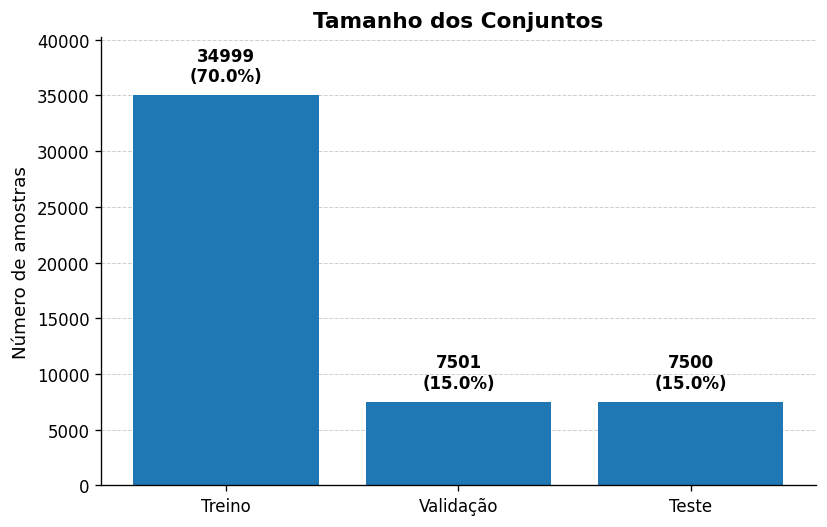

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

# Gera índices de treino, validação e teste, estratificados
def stratified_idxs(y: np.ndarray, test_size: float = 0.15, val_size: float = 0.15, seed: int = 42):
    """
    Retorna índices (train_idx, val_idx, test_idx) mantendo a mesma proporção de classes em cada partição.
    - y: array de rótulos (classificação)
    - test_size: fração do total para o conjunto de teste (ex.: 0.15 = 15%)
    - val_size: fração do total para o conjunto de validação (ex.: 0.15 = 15%)
    - seed: semente para reprodutibilidade
    """
    assert 0 < test_size < 1 and 0 < val_size < 1, "test_size/val_size devem estar entre 0 e 1."
    assert (test_size + val_size) < 1, "A soma de test_size e val_size deve ser < 1."

    # Índices de 0..N-1
    idx = np.arange(len(y))

    # Split para separar TESTE
    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    trainval_idx, test_idx = next(sss1.split(idx, y))  # trainval_idx: parte que sobrou (treino+val); test_idx: conjunto de teste

    # Split  dentro de trainval para separar VALIDAÇÃO
    val_rel = val_size / (1 - test_size)  # fração relativa dentro do pool que sobrou
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=val_rel, random_state=seed)
    train_idx, val_idx = next(sss2.split(trainval_idx, y[trainval_idx]))

    return train_idx, val_idx, test_idx


# ===== Uso

y = df_small["target"].to_numpy(dtype=np.int64)
train_idx, val_idx, test_idx = stratified_idxs(y, test_size=0.15, val_size=0.15, seed=42)

sizes = {
    "Treino": len(train_idx),
    "Validação": len(val_idx),
    "Teste": len(test_idx)
}

# Plot simples dos tamanhos
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

labels = list(sizes.keys())
values = np.array(list(sizes.values()))
total = values.sum()

fig, ax = plt.subplots(figsize=(7, 4.5), dpi=120)
bars = ax.bar(labels, values)
ax.set_title("Tamanho dos Conjuntos", fontsize=13, fontweight="bold")
ax.set_ylabel("Número de amostras", fontsize=11)
ax.grid(axis="y", linestyle="--", linewidth=0.6, alpha=0.6)
ax.set_axisbelow(True)

# esconder spines sup/dir
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# rótulos com contagem + porcentagem
for rect, val in zip(bars, values):
    ax.annotate(
        f"{int(val)}\n({val/total:.1%})",
        xy=(rect.get_x() + rect.get_width()/2, rect.get_height()),
        xytext=(0, 6),
        textcoords="offset points",
        ha="center", va="bottom",
        fontsize=10, fontweight="bold"
    )
ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins='auto', integer=True))
ax.tick_params(axis="both", labelsize=10)
ax.margins(y=0.15)
plt.tight_layout()
plt.show()

## Arquitetura: GRU (Gated Recurrent Unit)

In [62]:
# ===== Modelo GRU embedda tokens, aplica dropout e processa as sequências =====
class SentimentGRU(nn.Module):
    def __init__(self, vocab_size: int, emb_dim: int = 300, hidden_dim: int = 128,
                 num_layers: int = 1, bidir: bool = True, emb_dropout: float = 0.2,
                 rnn_dropout: float = 0.0, pad_idx: int = 0, use_packing: bool = True):
        super().__init__()
        self.pad_idx = pad_idx
        self.use_packing = use_packing
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.emb_dropout = nn.Dropout(emb_dropout)
        self.gru = nn.GRU(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=(rnn_dropout if num_layers > 1 else 0.0),
            bidirectional=bidir
        )
        out_dim = hidden_dim * (2 if bidir else 1)
        self.head = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(out_dim, 1)
        )

    def forward(self, x: torch.Tensor, lengths: Optional[torch.Tensor] = None) -> torch.Tensor:
        emb = self.emb_dropout(self.embedding(x))
        if self.use_packing:
            if lengths is None:
                lengths = (x != self.pad_idx).sum(dim=1).cpu()
            packed = nn.utils.rnn.pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
            _, h = self.gru(packed)
        else:
            _, h = self.gru(emb)
        h_last = h[-1] if self.gru.bidirectional is False else torch.cat([h[-2], h[-1]], dim=1)
        logits = self.head(h_last).squeeze(1)
        return logits

# =================== Training ===================
@dataclass
class TrainCfg:
    epochs: int = 5
    lr: float = 5e-4
    weight_decay: float = 5e-4
    clip_norm: float = 1.0
    amp: bool = True


# ==============================================
def train_one(model: nn.Module, train_dl: DataLoader, val_dl: DataLoader, cfg: TrainCfg,
              pos_weight: Optional[torch.Tensor] = None, verbose: bool = True):
    device = next(model.parameters()).device
    opt  = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    sch  = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=cfg.lr, epochs=cfg.epochs, steps_per_epoch=len(train_dl))
    crit = nn.BCEWithLogitsLoss(pos_weight=(pos_weight.to(device) if pos_weight is not None else None))
    scaler = torch.cuda.amp.GradScaler(enabled=cfg.amp)

    def run_epoch(dl: DataLoader, train: bool):
        model.train(train)
        total, correct, loss_sum = 0, 0, 0.0
        for xb, Lb, yb in dl:
            xb, Lb, yb = xb.to(device), Lb.to(device), yb.to(device).float()
            with torch.cuda.amp.autocast(enabled=cfg.amp):
                logits = model(xb, Lb)
                loss = crit(logits, yb)
            if train:
                opt.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()
                nn.utils.clip_grad_norm_(model.parameters(), cfg.clip_norm)
                scaler.step(opt); scaler.update(); sch.step()
            preds = (logits >= 0).long()
            correct += (preds == yb.long()).sum().item()
            total   += yb.size(0)
            loss_sum += loss.item() * yb.size(0)
        return loss_sum/total, correct/total

    best = {"val_acc": -1.0, "state": None}
    history = {"tr_loss": [], "tr_acc": [], "va_loss": [], "va_acc": []}

    for ep in range(1, cfg.epochs+1):
        tr_loss, tr_acc = run_epoch(train_dl, True)
        va_loss, va_acc = run_epoch(val_dl,   False)
        history["tr_loss"].append(tr_loss); history["tr_acc"].append(tr_acc)
        history["va_loss"].append(va_loss); history["va_acc"].append(va_acc)
        if va_acc > best["val_acc"]:
            best["val_acc"] = va_acc
            best["state"] = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        if verbose:
            print(f"[{ep}/{cfg.epochs}] tr_loss={tr_loss:.4f} tr_acc={tr_acc:.4f} | val_loss={va_loss:.4f} val_acc={va_acc:.4f}")
    return model, history, best


    best = {"val_acc": -1.0, "state": None}
    history = {"tr_loss": [], "tr_acc": [], "va_loss": [], "va_acc": []}

    for ep in range(1, cfg.epochs + 1):
        tr_loss, tr_acc = run_epoch(train_dl, True)
        va_loss, va_acc = run_epoch(val_dl,   False)

        history["tr_loss"].append(tr_loss); history["tr_acc"].append(tr_acc)
        history["va_loss"].append(va_loss); history["va_acc"].append(va_acc)

        if va_acc > best["val_acc"]:
            best["val_acc"] = va_acc
            best["state"] = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

        if verbose:
            print(f"[{ep}/{cfg.epochs}] tr_loss={tr_loss:.4f} tr_acc={tr_acc:.4f} | val_loss={va_loss:.4f} val_acc={va_acc:.4f}")

    return model, history, best


# =================== Evaluation ===================
@torch.no_grad()
def eval_on(model: nn.Module, dl: DataLoader):
    device = next(model.parameters()).device
    model.eval()
    total, correct = 0, 0
    y_true, y_prob = [], []
    for xb, Lb, yb in dl:
        xb, Lb, yb = xb.to(device), Lb.to(device), yb.to(device).float()
        logits = model(xb, Lb)
        probs = torch.sigmoid(logits)
        preds = (logits >= 0).long()
        correct += (preds == yb.long()).sum().item()
        total   += yb.size(0)
        y_true.append(yb.detach().cpu())
        y_prob.append(probs.detach().cpu())
    y_true = torch.cat(y_true).numpy()
    y_prob = torch.cat(y_prob).numpy()
    acc = correct / total
    return {"acc": acc, "y_true": y_true, "y_prob": y_prob}


#### Dataloader

In [63]:
def make_dataloader_from_texts(
    texts: Iterable[str],
    y: np.ndarray,
    vocab: Dict[str,int],
    max_len: int,
    batch_size: int = 128,
    shuffle: bool = True,
    num_workers: Optional[int] = None,
    pad_idx: int = 0,
) -> DataLoader:
    X, L, y_t = sequences_to_tensor(texts, y, vocab, max_len, pad_idx=pad_idx)
    ds = TensorDataset(X, L, y_t)
    if num_workers is None:
        try:
            num_workers = max(2, os.cpu_count() // 2)
        except Exception:
            num_workers = 2
    return DataLoader(
        ds, batch_size=batch_size, shuffle=shuffle, drop_last=False,
        num_workers=num_workers, pin_memory=True, persistent_workers=(num_workers > 0)
    )

# =================== Variant preparation ===================
def prepare_variants_dataloaders(
    df: pd.DataFrame,
    text_cols: List[str],
    target_col: str = "target",
    test_size: float = 0.15,
    val_size: float = 0.15,
    seed: int = 42,
    max_len_percentile: float = 95.0,
    min_freq: int = 1,
    max_vocab_size: Optional[int] = None,
    batch_size: int = 128,
    pad_idx: int = 0,
    share_vocab_from: Optional[str] = None,
) -> Tuple[Dict[str,DataLoader], Dict[str,DataLoader], Dict[str,DataLoader], Dict[str,Dict]]:
    assert target_col in df.columns, f"{target_col} not in df"
    y = df[target_col].to_numpy(dtype=np.int64)
    idx_tr, idx_va, idx_te = stratified_idxs(y, test_size=test_size, val_size=val_size, seed=seed)

    train_dls, val_dls, test_dls, meta = {}, {}, {}, {}

    def text_len_list(series: pd.Series) -> List[int]:
        return [len(simple_tokenize(t)) for t in series]

    for col in text_cols:
        assert col in df.columns, f"{col} not in df"
        texts = df[col].astype(str)
        lens_train = text_len_list(texts.iloc[idx_tr])
        max_len = int(np.percentile(lens_train, max_len_percentile))
        max_len = max(4, max_len)
        if share_vocab_from and share_vocab_from in text_cols:
            if '_shared_vocab' not in meta:
                shared_texts = df[share_vocab_from].astype(str).iloc[idx_tr]
                shared_vocab = build_vocab_from_texts(shared_texts, min_freq=min_freq, max_size=max_vocab_size)
                meta['_shared_vocab'] = {'vocab': shared_vocab}
            vocab = meta['_shared_vocab']['vocab']
        else:
            vocab = build_vocab_from_texts(texts.iloc[idx_tr], min_freq=min_freq, max_size=max_vocab_size)
        pos_ratio = y[idx_tr].mean()
        neg_ratio = 1 - pos_ratio
        pos_weight = torch.tensor(neg_ratio / max(pos_ratio, 1e-6), dtype=torch.float32)
        tr_dl = make_dataloader_from_texts(texts.iloc[idx_tr], y[idx_tr], vocab, max_len, batch_size=batch_size, shuffle=True,  pad_idx=pad_idx)
        va_dl = make_dataloader_from_texts(texts.iloc[idx_va], y[idx_va], vocab, max_len, batch_size=batch_size, shuffle=False, pad_idx=pad_idx)
        te_dl = make_dataloader_from_texts(texts.iloc[idx_te], y[idx_te], vocab, max_len, batch_size=batch_size, shuffle=False, pad_idx=pad_idx)
        train_dls[col] = tr_dl
        val_dls[col]   = va_dl
        test_dls[col]  = te_dl
        meta[col] = {"vocab": vocab, "max_len": max_len, "pad_idx": pad_idx, "pos_weight": pos_weight}
    return train_dls, val_dls, test_dls, meta


#### Treino

In [64]:
# Define as colunas de texto a serem usadas
cols_text = ["text", "clean", "stemmed", "lemmatized"]
TARGET_COL = "target"

train_dls, val_dls, test_dls, meta = prepare_variants_dataloaders(
    df_small, # Use df_small instead of df
    text_cols=cols_text,
    target_col=TARGET_COL,
    batch_size=128,
    share_vocab_from='clean' if 'clean' in cols_text and len(cols_text) > 1 else None
)

# Mostrar resumo
for v in cols_text:
    print(f"[{v}] max_len={meta[v]['max_len']}, vocab={len(meta[v]['vocab'])}")

[text] max_len=26, vocab=28120
[clean] max_len=27, vocab=28120
[stemmed] max_len=27, vocab=28120
[lemmatized] max_len=27, vocab=28120


In [65]:
histories = {}
results = {}

EPOCHS = 15
LR = 5e-4
WD = 5e-4
HIDDEN = 128
EMB = 300

for v in cols_text[:4]:
    print(f"\n=== Treinando variante: {v} ===")
    tr_dl, va_dl, te_dl = train_dls[v], val_dls[v], test_dls[v]
    vocab = meta[v]['vocab']; pad_idx = meta[v]['pad_idx']; pos_weight = meta[v]['pos_weight']

    model = SentimentGRU(
        vocab_size=len(vocab), emb_dim=EMB, hidden_dim=HIDDEN,
        num_layers=1, bidir=True, emb_dropout=0.2, rnn_dropout=0.0, pad_idx=pad_idx
    ) # .to(device)

    cfg = TrainCfg(epochs=EPOCHS, lr=LR, weight_decay=WD, clip_norm=1.0, amp=True)
    model, history, best = train_one(model, tr_dl, va_dl, cfg, pos_weight=pos_weight, verbose=True)

    # Avaliação no teste
    model.load_state_dict(best['state'])
    test_metrics = eval_on(model, te_dl)
    acc = test_metrics['acc']

    histories[v] = history
    results[v] = {'acc_test': acc}
    print(f"[{v}] acc_test = {acc:.4f}")



=== Treinando variante: text ===


/tmp/ipython-input-2316794200.py:55: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=cfg.amp)
/tmp/ipython-input-2316794200.py:62: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.amp):


[1/15] tr_loss=0.6934 tr_acc=0.5345 | val_loss=0.6742 val_acc=0.5803
[2/15] tr_loss=0.6655 tr_acc=0.5959 | val_loss=0.6443 val_acc=0.6260
[3/15] tr_loss=0.6245 tr_acc=0.6503 | val_loss=0.5911 val_acc=0.6843
[4/15] tr_loss=0.5688 tr_acc=0.7013 | val_loss=0.5439 val_acc=0.7276
[5/15] tr_loss=0.5330 tr_acc=0.7333 | val_loss=0.5285 val_acc=0.7404
[6/15] tr_loss=0.5052 tr_acc=0.7534 | val_loss=0.5181 val_acc=0.7487
[7/15] tr_loss=0.4834 tr_acc=0.7678 | val_loss=0.5073 val_acc=0.7568
[8/15] tr_loss=0.4621 tr_acc=0.7784 | val_loss=0.5059 val_acc=0.7624
[9/15] tr_loss=0.4456 tr_acc=0.7930 | val_loss=0.5084 val_acc=0.7616
[10/15] tr_loss=0.4358 tr_acc=0.8005 | val_loss=0.5107 val_acc=0.7638
[11/15] tr_loss=0.4293 tr_acc=0.8044 | val_loss=0.5091 val_acc=0.7654
[12/15] tr_loss=0.4235 tr_acc=0.8081 | val_loss=0.5093 val_acc=0.7652
[13/15] tr_loss=0.4204 tr_acc=0.8071 | val_loss=0.5101 val_acc=0.7667
[14/15] tr_loss=0.4148 tr_acc=0.8124 | val_loss=0.5102 val_acc=0.7651
[15/15] tr_loss=0.4165 tr_acc

### Resultados

In [66]:
res_df = pd.DataFrame([{'Variante': k, **v} for k, v in results.items()]).sort_values('acc_test', ascending=False)
res_df.reset_index(drop=True, inplace=True)
res_df

,Variante,acc_test
0,lemmatized,0.814667
1,clean,0.814400
2,text,0.805733
3,stemmed,0.796400


In [67]:
# Seleciona a melhor variante pela acurácia
best_var = res_df.iloc[0]["Variante"]

test_ds = test_dls[best_var].dataset
X_all, L_all, y_all = test_ds.tensors

idxs = random.sample(range(len(test_ds)), 5)

inv_vocab = {idx: tok for tok, idx in meta[best_var]["vocab"].items()}
pad_idx   = meta[best_var]["pad_idx"]

rows = []
model.eval()
with torch.no_grad():
    for i in idxs:
        xb = X_all[i].unsqueeze(0).to(next(model.parameters()).device)
        Lb = L_all[i].unsqueeze(0).to(next(model.parameters()).device)
        y_true = int(y_all[i].item())

        logit = model(xb, Lb)
        prob  = torch.sigmoid(logit).item()
        pred  = int(prob >= 0.5)

        # reconstruir texto (sem pad)
        toks = [inv_vocab.get(int(t), "<unk>") for t in X_all[i].cpu().numpy() if int(t) != pad_idx]
        text = " ".join(toks)

        emoji = "✅" if pred == y_true else "❌"

        rows.append({
            "Variante": best_var,
            "Texto": text,
            "Rótulo_verdadeiro": y_true,
            "Predição": f"{pred} {emoji}",
            "Probabilidade": round(prob, 4)
        })

df_exemplos = pd.DataFrame(rows)
df_exemplos

,Variante,Texto,Rótulo_verdadeiro,Predição,Probabilidade
0,lemmatized,no 8th win for rossi very sad,0,0 ✅,0.0089
1,lemmatized,user ahh you tweet ecstatic com lt 33 exc suck...,0,0 ✅,0.0990
2,lemmatized,go to bed let hope exc have trouble sleep thin...,0,0 ✅,0.0147
3,lemmatized,user sonny with a chance be so cool i hope you...,0,1 ❌,0.9022
4,lemmatized,user i don t have any of those color of course...,0,0 ✅,0.2643


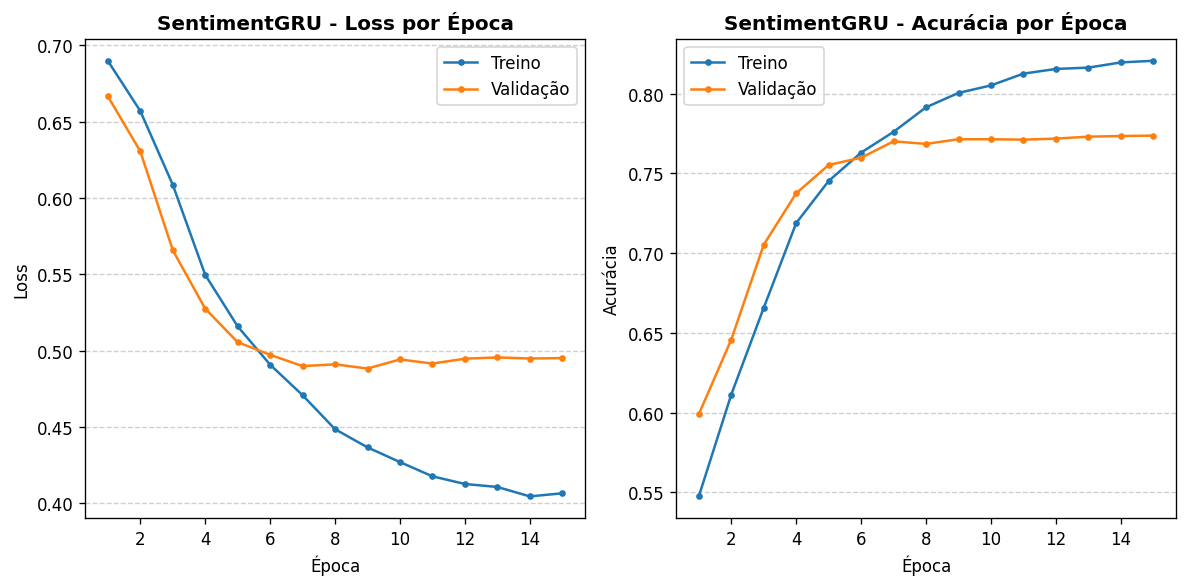

In [68]:
# Seleciona a história da melhor variante
history = histories[best_var]

# TODO: Adicionar a função plot_history_curves, se ainda não estiver presente
def plot_history_curves(history: Dict[str, List[float]], title_prefix: str = ""):
    epochs = range(1, len(history['tr_loss']) + 1)
    plt.figure(figsize=(10, 5), dpi=120)

    # Curvas de Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['tr_loss'], label='Treino', marker='.')
    plt.plot(epochs, history['va_loss'], label='Validação', marker='.')
    plt.title(f'{title_prefix} - Loss por Época', fontsize=12, fontweight='bold')
    plt.xlabel('Época', fontsize=10)
    plt.ylabel('Loss', fontsize=10)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Curvas de Acurácia
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['tr_acc'], label='Treino', marker='.')
    plt.plot(epochs, history['va_acc'], label='Validação', marker='.')
    plt.title(f'{title_prefix} - Acurácia por Época', fontsize=12, fontweight='bold')
    plt.xlabel('Época', fontsize=10)
    plt.ylabel('Acurácia', fontsize=10)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()


plot_history_curves(history, title_prefix="SentimentGRU")